#LSTMa

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


# Predict Sequence length : 12H

100%|██████████| 100/100 [01:07<00:00,  1.48it/s, loss=0.00182]


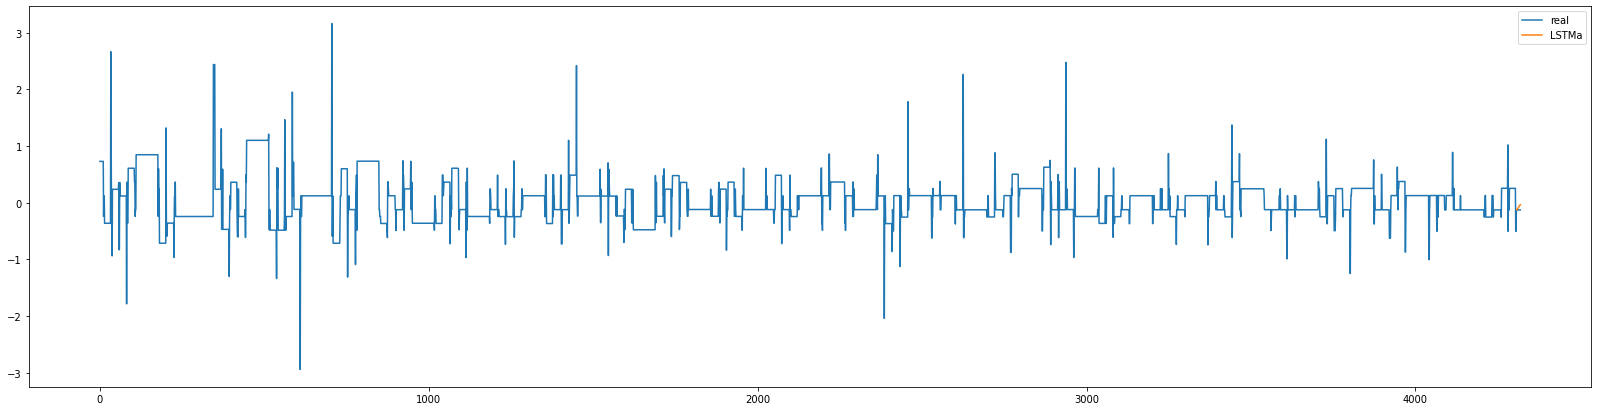

LSTMa
----------------------------------------
MSE: 0.0030218248470024415 |
MAE : 0.04543009126537909
LSTMa 모델이 동작하는 시간 : 77.00008249282837



In [2]:
# LSTMa 시간 측정 시작

import time

time0 = time.time() 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import trange
import random

data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv", encoding='CP949')

data.head()

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
data["종가"] = min_max_scaler.fit_transform(data["종가"].to_numpy().reshape(-1,1))

train = data[:-12]
train = train["종가"].to_numpy()

test = data[-12:]
test = test["종가"].to_numpy()

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda", index=0)

class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)
        
        return output, self.hidden

class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs

    def predict(self, inputs, target_len):
        inputs = inputs.unsqueeze(0)
        self.eval()
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

iw = 12*2
ow = 12

train_dataset = windowDataset(train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)
# y_train_loader = DataLoader(y_train, batch_size=5)

model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)
# model.train_model(X_train.to(device), y_train.to(device), n_epochs=100, target_len=ow, batch_size=5, training_bprediction="mixed_teacher_forcing", teacher_forcing_ratio=0.6, learning_rate=0.01, dynamic_tf=False)

#5000으로 할 경우 시간도 오래걸리고 에러도 커서 100으로 줄인다.

learning_rate=0.01
epoch = 100
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

from tqdm import tqdm

model.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

predict = model.predict(torch.tensor(train_dataset[0][0]).to(device).float(), target_len=ow)
real = train_dataset[0][1]

predict = model.predict(torch.tensor(train[-12*2:]).reshape(-1,1).to(device).float(), target_len=ow)
real = data["종가"].to_numpy()

predict_12 = min_max_scaler.inverse_transform(predict.reshape(-1,1))
real_12 = min_max_scaler.inverse_transform(real.reshape(-1,1))

plt.figure(figsize=(28,7))
plt.plot(range(0,4320), real_12[1:], label="real")
plt.plot(range(4320-12,4320), predict_12[-12:], label="LSTMa")

plt.legend()
plt.show()

# LSTMa 시간 측정 끝

TimeLSTMa_12 = time.time() - time0

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print('LSTMa_12')
print('-' * 40)
print('MSE: {} |\nMAE : {}\nLSTMa 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real_12[-12:], predict_12[-12:]), mean_absolute_error(real_12[-12:], predict_12[-12:]), TimeLSTMa_12))

# Predict Sequence length : 24H


100%|██████████| 100/100 [01:59<00:00,  1.19s/it, loss=0.00187]


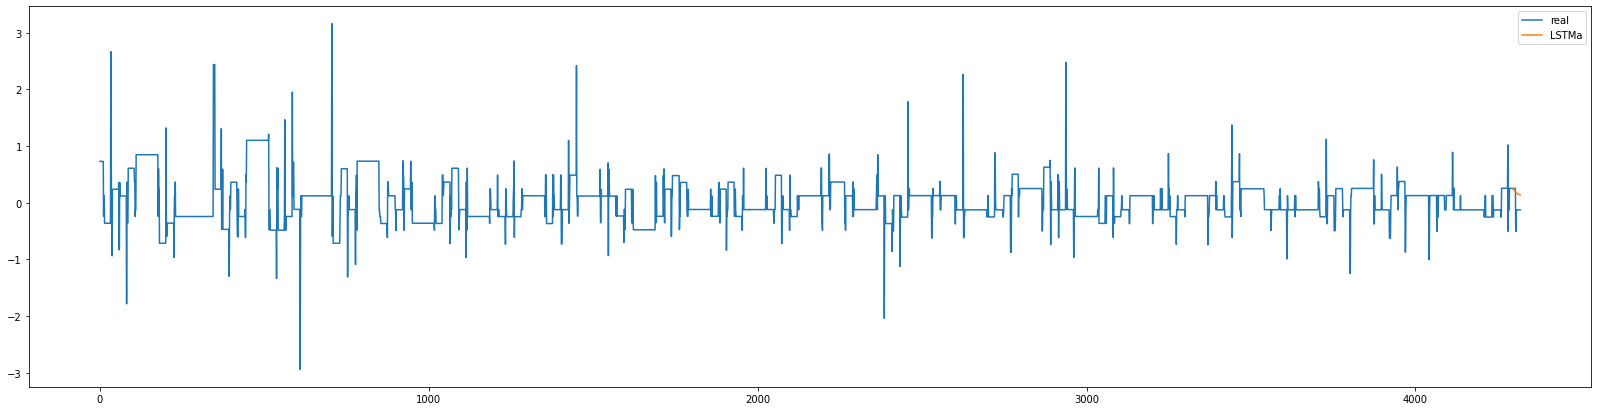

LSTMa
----------------------------------------
MSE: 0.08212634308156733 |
MAE : 0.21943952417543752
LSTMa 모델이 동작하는 시간 : 119.27938580513



In [3]:
# LSTMa 시간 측정 시작

import time

time0 = time.time() 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import trange
import random

data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv", encoding='CP949')

data.head()

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
data["종가"] = min_max_scaler.fit_transform(data["종가"].to_numpy().reshape(-1,1))

train = data[:-24*1]
train = train["종가"].to_numpy()

test = data[-24*1:]
test = test["종가"].to_numpy()

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda", index=0)

class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)
        
        return output, self.hidden

class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs

    def predict(self, inputs, target_len):
        inputs = inputs.unsqueeze(0)
        self.eval()
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

iw = 24*1*2
ow = 24*1

train_dataset = windowDataset(train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)
# y_train_loader = DataLoader(y_train, batch_size=5)

model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)
# model.train_model(X_train.to(device), y_train.to(device), n_epochs=100, target_len=ow, batch_size=5, training_bprediction="mixed_teacher_forcing", teacher_forcing_ratio=0.6, learning_rate=0.01, dynamic_tf=False)

#5000으로 할 경우 시간도 오래걸리고 에러도 커서 100으로 줄인다.

learning_rate=0.01
epoch = 100
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

from tqdm import tqdm

model.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

predict = model.predict(torch.tensor(train_dataset[0][0]).to(device).float(), target_len=ow)
real = train_dataset[0][1]

predict = model.predict(torch.tensor(train[-24*1*2:]).reshape(-1,1).to(device).float(), target_len=ow)
real = data["종가"].to_numpy()

predict_24 = min_max_scaler.inverse_transform(predict.reshape(-1,1))
real_24 = min_max_scaler.inverse_transform(real.reshape(-1,1))

plt.figure(figsize=(28,7))
plt.plot(range(0,4320), real_24[1:], label="real")
plt.plot(range(4320-24*1,4320), predict_24[-24*1:], label="LSTMa")

plt.legend()
plt.show()

# LSTMa 시간 측정 끝

TimeLSTMa_24 = time.time() - time0

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print('LSTMa')
print('-' * 40)
print('MSE: {} |\nMAE : {}\nLSTMa 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real_24[-24*1:], predict_24[-24*1:]), mean_absolute_error(real_24[-24*1:], predict_24[-24*1:]), TimeLSTMa_24))

# Predict Sequence length : 48H

100%|██████████| 100/100 [03:36<00:00,  2.17s/it, loss=0.00168]


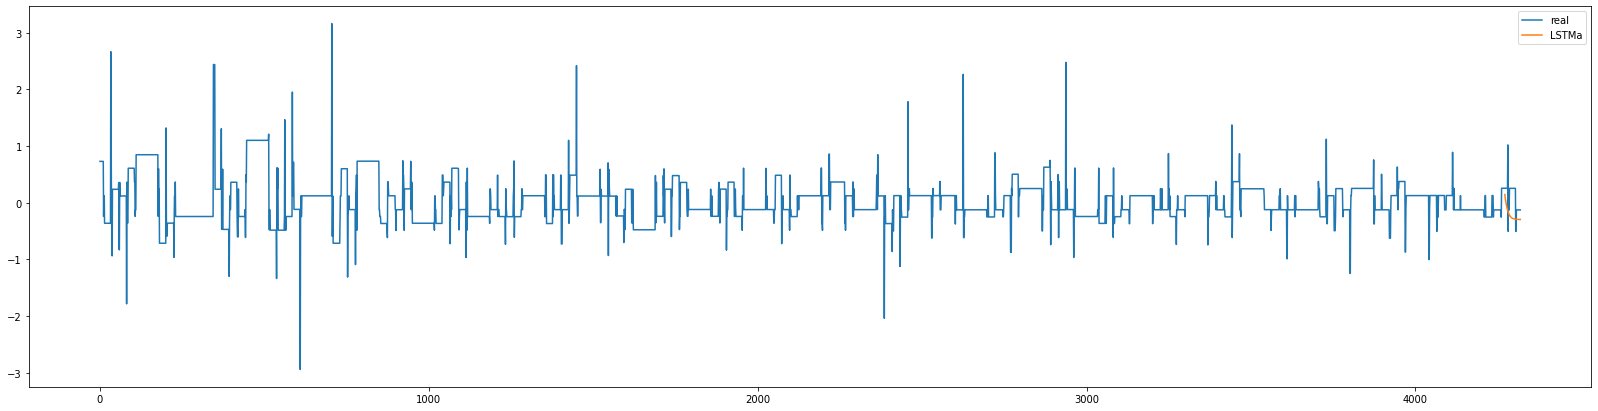

LSTMa
----------------------------------------
MSE: 0.16619666721367626 |
MAE : 0.3533203044859503
LSTMa 모델이 동작하는 시간 : 217.16237092018127



In [4]:
# LSTMa 시간 측정 시작

import time

time0 = time.time() 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import trange
import random

data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv", encoding='CP949')

data.head()

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
data["종가"] = min_max_scaler.fit_transform(data["종가"].to_numpy().reshape(-1,1))

train = data[:-24*2]
train = train["종가"].to_numpy()

test = data[-24*2:]
test = test["종가"].to_numpy()

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda", index=0)

class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)
        
        return output, self.hidden

class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs

    def predict(self, inputs, target_len):
        inputs = inputs.unsqueeze(0)
        self.eval()
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

iw = 24*2*2
ow = 24*2

train_dataset = windowDataset(train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)
# y_train_loader = DataLoader(y_train, batch_size=5)

model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)
# model.train_model(X_train.to(device), y_train.to(device), n_epochs=100, target_len=ow, batch_size=5, training_bprediction="mixed_teacher_forcing", teacher_forcing_ratio=0.6, learning_rate=0.01, dynamic_tf=False)

#5000으로 할 경우 시간도 오래걸리고 에러도 커서 100으로 줄인다.

learning_rate=0.01
epoch = 100
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

from tqdm import tqdm

model.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

predict = model.predict(torch.tensor(train_dataset[0][0]).to(device).float(), target_len=ow)
real = train_dataset[0][1]

predict = model.predict(torch.tensor(train[-24*2*2:]).reshape(-1,1).to(device).float(), target_len=ow)
real = data["종가"].to_numpy()

predict_48 = min_max_scaler.inverse_transform(predict.reshape(-1,1))
real_48 = min_max_scaler.inverse_transform(real.reshape(-1,1))

plt.figure(figsize=(28,7))
plt.plot(range(0,4320), real_48[1:], label="real")
plt.plot(range(4320-24*2,4320), predict_48[-24*2:], label="LSTMa")

plt.legend()
plt.show()

# LSTMa 시간 측정 끝

TimeLSTMa_48 = time.time() - time0

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print('LSTMa')
print('-' * 40)
print('MSE: {} |\nMAE : {}\nLSTMa 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real_48[-24*2:], predict_48[-24*2:]), mean_absolute_error(real_48[-24*2:], predict_48[-24*2:]), TimeLSTMa_48))

# Predict Sequence length : 96H

100%|██████████| 100/100 [06:50<00:00,  4.10s/it, loss=0.00170]


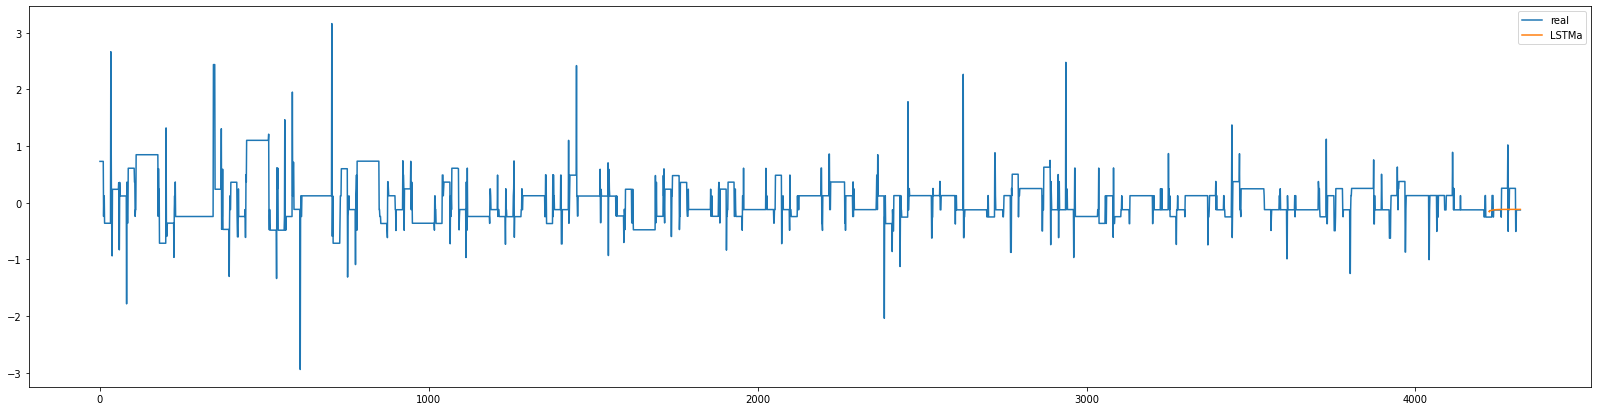

LSTMa
----------------------------------------
MSE: 0.07881714888931228 |
MAE : 0.2019091687972757
LSTMa 모델이 동작하는 시간 : 410.47794818878174



In [5]:
# LSTMa 시간 측정 시작

import time

time0 = time.time() 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import trange
import random

data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv", encoding='CP949')

data.head()

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
data["종가"] = min_max_scaler.fit_transform(data["종가"].to_numpy().reshape(-1,1))

train = data[:-24*4]
train = train["종가"].to_numpy()

test = data[-24*4:]
test = test["종가"].to_numpy()

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda", index=0)

class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)
        
        return output, self.hidden

class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs

    def predict(self, inputs, target_len):
        inputs = inputs.unsqueeze(0)
        self.eval()
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

iw = 24*4*2
ow = 24*4

train_dataset = windowDataset(train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)
# y_train_loader = DataLoader(y_train, batch_size=5)

model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)
# model.train_model(X_train.to(device), y_train.to(device), n_epochs=100, target_len=ow, batch_size=5, training_bprediction="mixed_teacher_forcing", teacher_forcing_ratio=0.6, learning_rate=0.01, dynamic_tf=False)

#5000으로 할 경우 시간도 오래걸리고 에러도 커서 100으로 줄인다.

learning_rate=0.01
epoch = 100
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

from tqdm import tqdm

model.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

predict = model.predict(torch.tensor(train_dataset[0][0]).to(device).float(), target_len=ow)
real = train_dataset[0][1]

predict = model.predict(torch.tensor(train[-24*4*2:]).reshape(-1,1).to(device).float(), target_len=ow)
real = data["종가"].to_numpy()

predict_96 = min_max_scaler.inverse_transform(predict.reshape(-1,1))
real_96 = min_max_scaler.inverse_transform(real.reshape(-1,1))

plt.figure(figsize=(28,7))
plt.plot(range(0,4320), real_96[1:], label="real")
plt.plot(range(4320-24*4,4320), predict_96[-24*4:], label="LSTMa")

plt.legend()
plt.show()

# LSTMa 시간 측정 끝

TimeLSTMa_96 = time.time() - time0

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print('LSTMa')
print('-' * 40)
print('MSE: {} |\nMAE : {}\nLSTMa 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real_96[-24*4:], predict_96[-24*4:]), mean_absolute_error(real_96[-24*4:], predict_96[-24*4:]), TimeLSTMa_96))

# Predict Sequence length : 192H

100%|██████████| 100/100 [12:28<00:00,  7.49s/it, loss=0.00159]


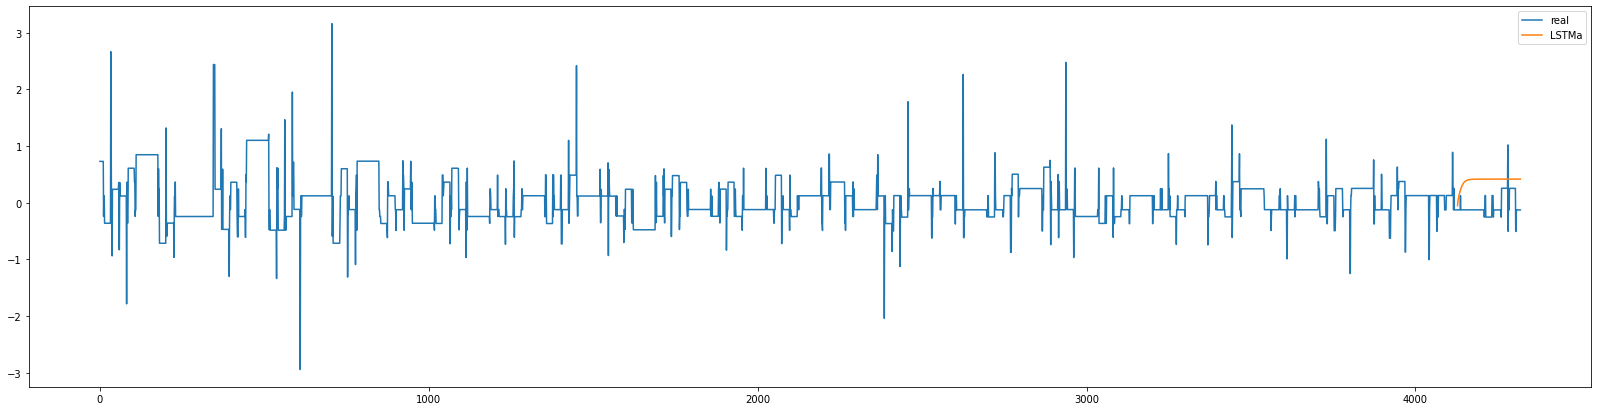

LSTMa
----------------------------------------
MSE: 0.23971218873330594 |
MAE : 0.453070306228329
LSTMa 모델이 동작하는 시간 : 749.0083546638489



In [6]:
# LSTMa 시간 측정 시작

import time

time0 = time.time() 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import trange
import random

data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv", encoding='CP949')

data.head()

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
data["종가"] = min_max_scaler.fit_transform(data["종가"].to_numpy().reshape(-1,1))

train = data[:-24*8]
train = train["종가"].to_numpy()

test = data[-24*8:]
test = test["종가"].to_numpy()

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda", index=0)

class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)
        
        return output, self.hidden

class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs

    def predict(self, inputs, target_len):
        inputs = inputs.unsqueeze(0)
        self.eval()
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

iw = 24*8*2
ow = 24*8

train_dataset = windowDataset(train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)
# y_train_loader = DataLoader(y_train, batch_size=5)

model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)
# model.train_model(X_train.to(device), y_train.to(device), n_epochs=100, target_len=ow, batch_size=5, training_bprediction="mixed_teacher_forcing", teacher_forcing_ratio=0.6, learning_rate=0.01, dynamic_tf=False)

#5000으로 할 경우 시간도 오래걸리고 에러도 커서 100으로 줄인다.

learning_rate=0.01
epoch = 100
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

from tqdm import tqdm

model.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

predict = model.predict(torch.tensor(train_dataset[0][0]).to(device).float(), target_len=ow)
real = train_dataset[0][1]

predict = model.predict(torch.tensor(train[-24*8*2:]).reshape(-1,1).to(device).float(), target_len=ow)
real = data["종가"].to_numpy()

predict_192 = min_max_scaler.inverse_transform(predict.reshape(-1,1))
real_192 = min_max_scaler.inverse_transform(real.reshape(-1,1))

plt.figure(figsize=(28,7))
plt.plot(range(0,4320), real_192[1:], label="real")
plt.plot(range(4320-24*8,4320), predict_192[-24*8:], label="LSTMa")

plt.legend()
plt.show()

# LSTMa 시간 측정 끝

TimeLSTMa_192 = time.time() - time0

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print('LSTMa')
print('-' * 40)
print('MSE: {} |\nMAE : {}\nLSTMa 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real_192[-24*8:], predict_192[-24*8:]), mean_absolute_error(real_192[-24*8:], predict_192[-24*8:]), TimeLSTMa_192))

# Predict Sequence length : 336H

100%|██████████| 100/100 [18:18<00:00, 10.98s/it, loss=0.00124]


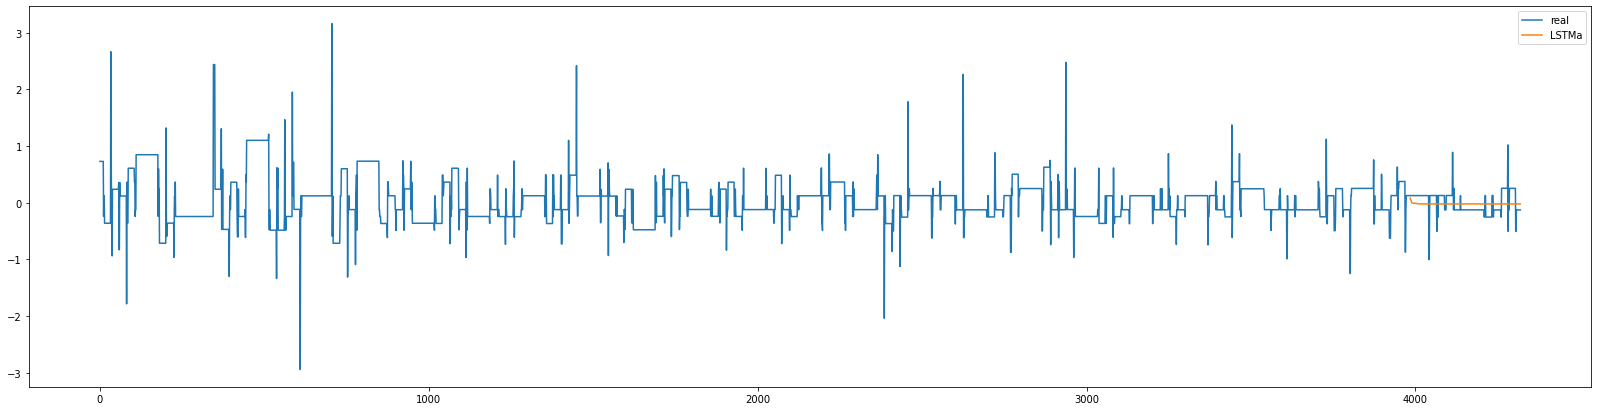

LSTMa
----------------------------------------
MSE: 0.039828156474817265 |
MAE : 0.16472312563469216
LSTMa 모델이 동작하는 시간 : 1098.8669073581696



In [7]:
# LSTMa 시간 측정 시작

import time

time0 = time.time() 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import trange
import random

data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv", encoding='CP949')

data.head()

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
data["종가"] = min_max_scaler.fit_transform(data["종가"].to_numpy().reshape(-1,1))

train = data[:-24*14]
train = train["종가"].to_numpy()

test = data[-24*14:]
test = test["종가"].to_numpy()

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda", index=0)

class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)
        
        return output, self.hidden

class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs

    def predict(self, inputs, target_len):
        inputs = inputs.unsqueeze(0)
        self.eval()
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

iw = 24*14*2
ow = 24*14

train_dataset = windowDataset(train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)
# y_train_loader = DataLoader(y_train, batch_size=5)

model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)
# model.train_model(X_train.to(device), y_train.to(device), n_epochs=100, target_len=ow, batch_size=5, training_bprediction="mixed_teacher_forcing", teacher_forcing_ratio=0.6, learning_rate=0.01, dynamic_tf=False)

#5000으로 할 경우 시간도 오래걸리고 에러도 커서 100으로 줄인다.

learning_rate=0.01
epoch = 100
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

from tqdm import tqdm

model.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

predict = model.predict(torch.tensor(train_dataset[0][0]).to(device).float(), target_len=ow)
real = train_dataset[0][1]

predict = model.predict(torch.tensor(train[-24*14*2:]).reshape(-1,1).to(device).float(), target_len=ow)
real = data["종가"].to_numpy()

predict_336 = min_max_scaler.inverse_transform(predict.reshape(-1,1))
real_336 = min_max_scaler.inverse_transform(real.reshape(-1,1))

plt.figure(figsize=(28,7))
plt.plot(range(0,4320), real_336[1:], label="real")
plt.plot(range(4320-24*14,4320), predict_336[-24*14:], label="LSTMa")

plt.legend()
plt.show()

# LSTMa 시간 측정 끝

TimeLSTMa_336 = time.time() - time0

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print('LSTMa')
print('-' * 40)
print('MSE: {} |\nMAE : {}\nLSTMa 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real_336[-24*14:], predict_336[-24*14:]), mean_absolute_error(real_336[-24*14:], predict_336[-24*14:]), TimeLSTMa_336))

# Predict Sequence length : 480H

100%|██████████| 100/100 [21:13<00:00, 12.73s/it, loss=0.00121]


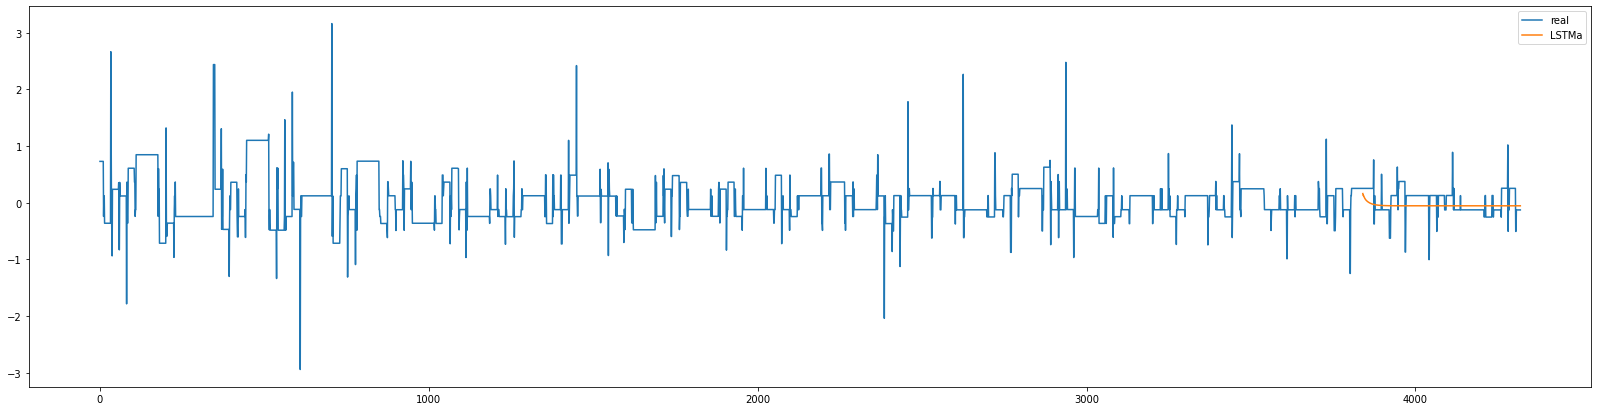

LSTMa
----------------------------------------
MSE: 0.053022664018531736 |
MAE : 0.18395657005790214
LSTMa 모델이 동작하는 시간 : 1273.6843218803406



In [8]:
# LSTMa 시간 측정 시작

import time

time0 = time.time() 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import trange
import random

data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv", encoding='CP949')

data.head()

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
data["종가"] = min_max_scaler.fit_transform(data["종가"].to_numpy().reshape(-1,1))

train = data[:-24*20]
train = train["종가"].to_numpy()

test = data[-24*20:]
test = test["종가"].to_numpy()

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda", index=0)

class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)
        
        return output, self.hidden

class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs

    def predict(self, inputs, target_len):
        inputs = inputs.unsqueeze(0)
        self.eval()
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

iw = 24*20*2
ow = 24*20

train_dataset = windowDataset(train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)
# y_train_loader = DataLoader(y_train, batch_size=5)

model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)
# model.train_model(X_train.to(device), y_train.to(device), n_epochs=100, target_len=ow, batch_size=5, training_bprediction="mixed_teacher_forcing", teacher_forcing_ratio=0.6, learning_rate=0.01, dynamic_tf=False)

#5000으로 할 경우 시간도 오래걸리고 에러도 커서 100으로 줄인다.

learning_rate=0.01
epoch = 100
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

from tqdm import tqdm

model.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

predict = model.predict(torch.tensor(train_dataset[0][0]).to(device).float(), target_len=ow)
real = train_dataset[0][1]

predict = model.predict(torch.tensor(train[-24*20*2:]).reshape(-1,1).to(device).float(), target_len=ow)
real = data["종가"].to_numpy()

predict_480 = min_max_scaler.inverse_transform(predict.reshape(-1,1))
real_480 = min_max_scaler.inverse_transform(real.reshape(-1,1))

plt.figure(figsize=(28,7))
plt.plot(range(0,4320), real_480[1:], label="real")
plt.plot(range(4320-24*20,4320), predict_480[-24*20:], label="LSTMa")

plt.legend()
plt.show()

# LSTMa 시간 측정 끝

TimeLSTMa_480 = time.time() - time0

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print('LSTMa')
print('-' * 40)
print('MSE: {} |\nMAE : {}\nLSTMa 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real_480[-24*20:], predict_480[-24*20:]), mean_absolute_error(real_480[-24*20:], predict_480[-24*20:]), TimeLSTMa_480))

# Predict Sequence length : 720H

100%|██████████| 100/100 [19:33<00:00, 11.73s/it, loss=0.00129]


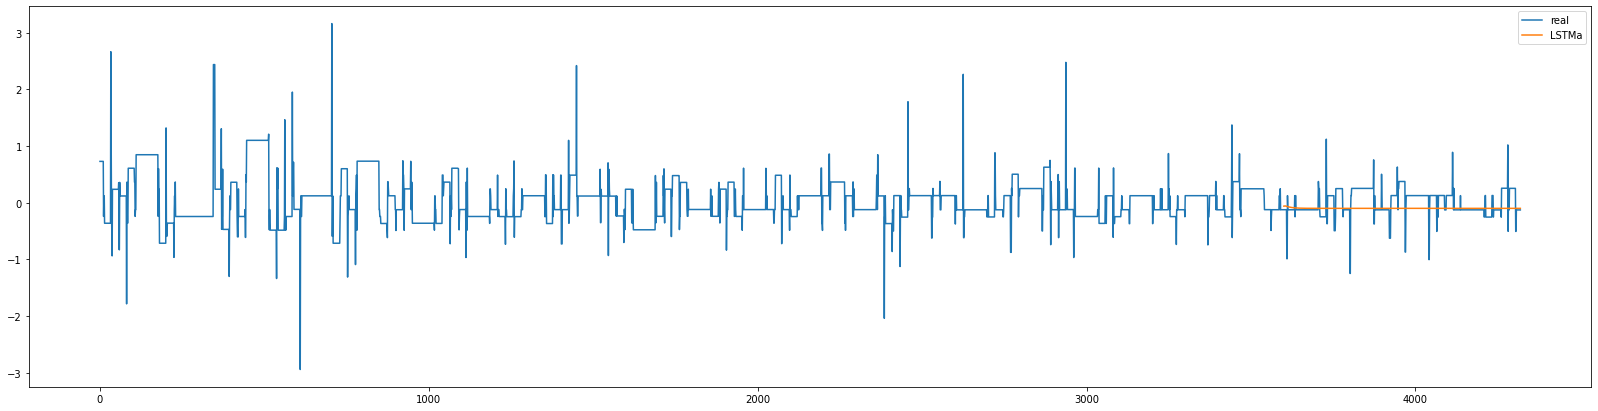

LSTMa
----------------------------------------
MSE: 0.06539498161381845 |
MAE : 0.18589044356041795
LSTMa 모델이 동작하는 시간 : 1173.857326745987



In [9]:
# LSTMa 시간 측정 시작

import time

time0 = time.time() 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import trange
import random

data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv", encoding='CP949')

data.head()

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
data["종가"] = min_max_scaler.fit_transform(data["종가"].to_numpy().reshape(-1,1))

train = data[:-24*30]
train = train["종가"].to_numpy()

test = data[-24*30:]
test = test["종가"].to_numpy()

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda", index=0)

class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)
        
        return output, self.hidden

class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs

    def predict(self, inputs, target_len):
        inputs = inputs.unsqueeze(0)
        self.eval()
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

iw = 24*30*2
ow = 24*30

train_dataset = windowDataset(train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)
# y_train_loader = DataLoader(y_train, batch_size=5)

model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)
# model.train_model(X_train.to(device), y_train.to(device), n_epochs=100, target_len=ow, batch_size=5, training_bprediction="mixed_teacher_forcing", teacher_forcing_ratio=0.6, learning_rate=0.01, dynamic_tf=False)

#5000으로 할 경우 시간도 오래걸리고 에러도 커서 100으로 줄인다.

learning_rate=0.01
epoch = 100
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

from tqdm import tqdm

model.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

predict = model.predict(torch.tensor(train_dataset[0][0]).to(device).float(), target_len=ow)
real = train_dataset[0][1]

predict = model.predict(torch.tensor(train[-24*30:]).reshape(-1,1).to(device).float(), target_len=ow)
real = data["종가"].to_numpy()

predict_720 = min_max_scaler.inverse_transform(predict.reshape(-1,1))
real_720 = min_max_scaler.inverse_transform(real.reshape(-1,1))

plt.figure(figsize=(28,7))
plt.plot(range(0,4320), real_720[1:], label="real")
plt.plot(range(4320-24*30,4320), predict_720[-24*30:], label="LSTMa")

plt.legend()
plt.show()

# LSTMa 시간 측정 끝

TimeLSTMa_720 = time.time() - time0

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print('LSTMa')
print('-' * 40)
print('MSE: {} |\nMAE : {}\nLSTMa 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real_720[-24*30:], predict_720[-24*30:]), mean_absolute_error(real_720[-24*30:], predict_720[-24*30:]), TimeLSTMa_720))

In [12]:
print('LSTMa_12')
print('MSE: {} |\nMAE : {}\nLSTMa 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real_12[-12:], predict_12[-12:]), mean_absolute_error(real_12[-12:], predict_12[-12:]), TimeLSTMa_12))
print('-' * 40)
print('LSTMa_24')
print('MSE: {} |\nMAE : {}\nLSTMa 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real_24[-24*1:], predict_24[-24*1:]), mean_absolute_error(real_24[-24*1:], predict_24[-24*1:]), TimeLSTMa_24))
print('-' * 40)
print('LSTMa_48')
print('MSE: {} |\nMAE : {}\nLSTMa 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real_48[-24*2:], predict_48[-24*2:]), mean_absolute_error(real_48[-24*2:], predict_48[-24*2:]), TimeLSTMa_48))
print('-' * 40)
print('LSTMa_192')
print('MSE: {} |\nMAE : {}\nLSTMa 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(real_192[-24*8:], predict_192[-24*8:]), mean_absolute_error(real_192[-24*8:], predict_192[-24*8:]), TimeLSTMa_192))

LSTMa_12
MSE: 0.0030218248470024415 |
MAE : 0.04543009126537909
LSTMa 모델이 동작하는 시간 : 77.00008249282837

----------------------------------------
LSTMa_24
MSE: 0.08212634308156733 |
MAE : 0.21943952417543752
LSTMa 모델이 동작하는 시간 : 119.27938580513

----------------------------------------
LSTMa_48
MSE: 0.16619666721367626 |
MAE : 0.3533203044859503
LSTMa 모델이 동작하는 시간 : 217.16237092018127

----------------------------------------
LSTMa_192
MSE: 0.23971218873330594 |
MAE : 0.453070306228329
LSTMa 모델이 동작하는 시간 : 749.0083546638489

